<h1> Fashion MNIST Mini Project Summary


<h2> Overview


I undertook this project in efforts to better understand the keras library and to get my first real 
end to end image classification project under my belt. I started off with simple convolutional neural networks
and worked my way to deeper more complex models. Along the way I dabbled with data augmentation, google colab (GPUs),
callbacks, and saving my models to file.

My best model achieved an accuracy of 94% on the test set, which according to the [fashion-mnist](https://github.com/zalandoresearch/fashion-mnist) 
github page is pretty decent. We will take a look at this and other metrics in more detail to come.


But first let's get the necessary modules and helper functions loaded. 


In [1]:
# Loading in modules
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data helper function
def load_data(file_path="data/fashion_mnist_scaled.npz"):
    data = np.load(file_path, allow_pickle=True)
    X_train, y_train, X_test, y_test = [data[file] for file in data.files]
    return X_train, y_train, X_test, y_test


Using TensorFlow backend.


<h2> Initial Exploration and Benchmark


The road I went down was to create some very simple convnets. I wanted to get some quick feedback and 
get a solid benchmark, without waiting hours for my models to train. I went from a one layer network with 10
filters and gradually added more filters and layers until I got to a network with 4 conv layers. These networks were 
achieving accuracies of 89% - 92% on the validation set. All were trained on my personal computer.

The best network from this initial exploration was a one layer model with 30 filters. I achieved similar accuracies with the deeper
models, but the added complexity wasn't worth the very minimal improvements. Let's go ahead and load
this model from disk and look at it in more detail.


In [2]:
# Loading in model and data
simple_cnn = load_model("data/simple_cnn.h5")
X_train, y_train, X_test, y_test = load_data()


Here is a deeper look at the architecture of the model. Total learnable params are 59,100. Since it's a smaller
network I was able to train this model just fine on my computer using CPU's.


In [3]:
simple_cnn.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 30)        300       
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 28, 30)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 30)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5880)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                58810     
Total params: 59,110
Trainable params: 59,110
Non-trainable params: 0
_________________________________________________________________


Next let's take a look at how well it performs on the test set, which contains 10,000 images.


In [4]:
# Making predictions on the test set
pred_simple = simple_cnn.evaluate(X_test, y_test)[1]
print(f'Accuracy: {pred_simple * 100:.2f}%')


10000/10000 [==============================] - 2s 161us/step
Accuracy: 90.52%


The test accuracy is quite a bit less than the validation and training accuracy, so it looks like this model
is overfitting a bit. Regardless, this was a nice start and got me thinking about new ways to improve 
the performance of my models besides just messing with the architecture. 
<br />


<h2> Data Augmentation and GPU's


After this initial exploration I turned my efforts to data augmentation in hopes to improve the performance of my 
models. This was a great learning experience as this was my first time getting my feet wet with data augmentation. 
Keras made it real easy to create augmented data and then feed it into the model to train.  

To augment the data I went with random horizontal shifts, zooming, and rotating. I created two augmented images per 
each instance in the original dataset. I only trained on the augmented images, so my training size was doubled. Below
are examples of different random augmentations of the same image.

IMAGE GOES HERE


The details of the best model trained on the augmented data set are below. As you can see it's a deeper
model with far more filters than the previous simple cnn. It has over 1 million learnable params.


In [5]:
# Loading model and looking at its architecture
aug_mod = load_model("data/deep_cnn_best.h5")
aug_mod.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 28, 28, 480)       4800      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 480)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 480)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 240)       1037040   
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 240)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 240)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 120)        

Trying to train this model on my computer using CPUs took too long. My computer fans would kick on right away
and after several hours it would finally train. This doesn't seem terrible, but for such a simple classification
problem, I was wasn't willing to be that patient. 

I turned to Google Colab and utilized their free GPUs online. All it took was to convert my code from a .py file to
a .ipynb file. This sped up the learning process greatly and allowed me to train various models in short amount of time.
This was one of the big takeaways from doing this project. Don't sit around wasting time training on CPUs when 
google is offering you free GPUs to use.

Anyways back to the problem at hand...

Alright let's take a look at how this model did on the test set and dive deeper into the results.


In [14]:
pred_aug = aug_mod.predict_classes(X_test)
pred_prob_aug = aug_mod.predict(X_test)
acc_aug = accuracy_score(y_test, pred_aug)
print(f'Accuracy: {acc_aug*100}%')


Accuracy: 93.96%


Lets take a look at a confusion matrix to better understand how well this model is performing.


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1360d4d10>)

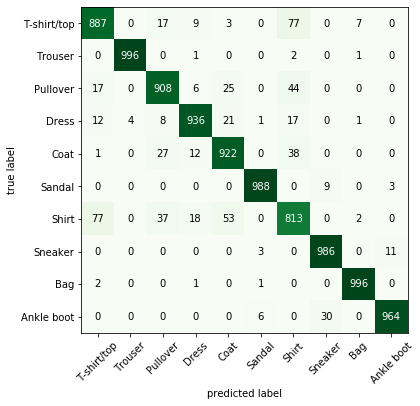

In [62]:
# Plotting confusion matrix
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
cm = confusion_matrix(y_test, pred_aug)
plot_confusion_matrix(conf_mat=cm, class_names=labels, cmap='Greens', figsize=(6, 6))


It looks like our model has the hardest time classifying Shirts, with an accuracy of 81.3%. It frequently 
confuses them with T-shirt/tops, which is reasonable. Frankly, I don't think I could distinguish the differences between these
categories. Let's take a deeper look at some of the images it misclassified.


Our model misclassified 604 images. We will just look at 25 of them to get an idea the mistakes its making.


In [13]:
wrong = pred_aug != y_test
np.sum(wrong)


604

In [24]:
wrong_x = X_test[wrong][:25]
wrong_y_pred = pred_aug[wrong][:25]
wrong_y_proba = np.max(pred_prob_aug[wrong], axis=1)[:25]
wrong_y_true = y_test[wrong][:25]



In [67]:
# Sanity check
print(wrong_x.shape, wrong_y_proba.shape)


(25, 28, 28, 1) (25,)


t: True Label

p: Predicted Label
 
prob: confidence in prediction

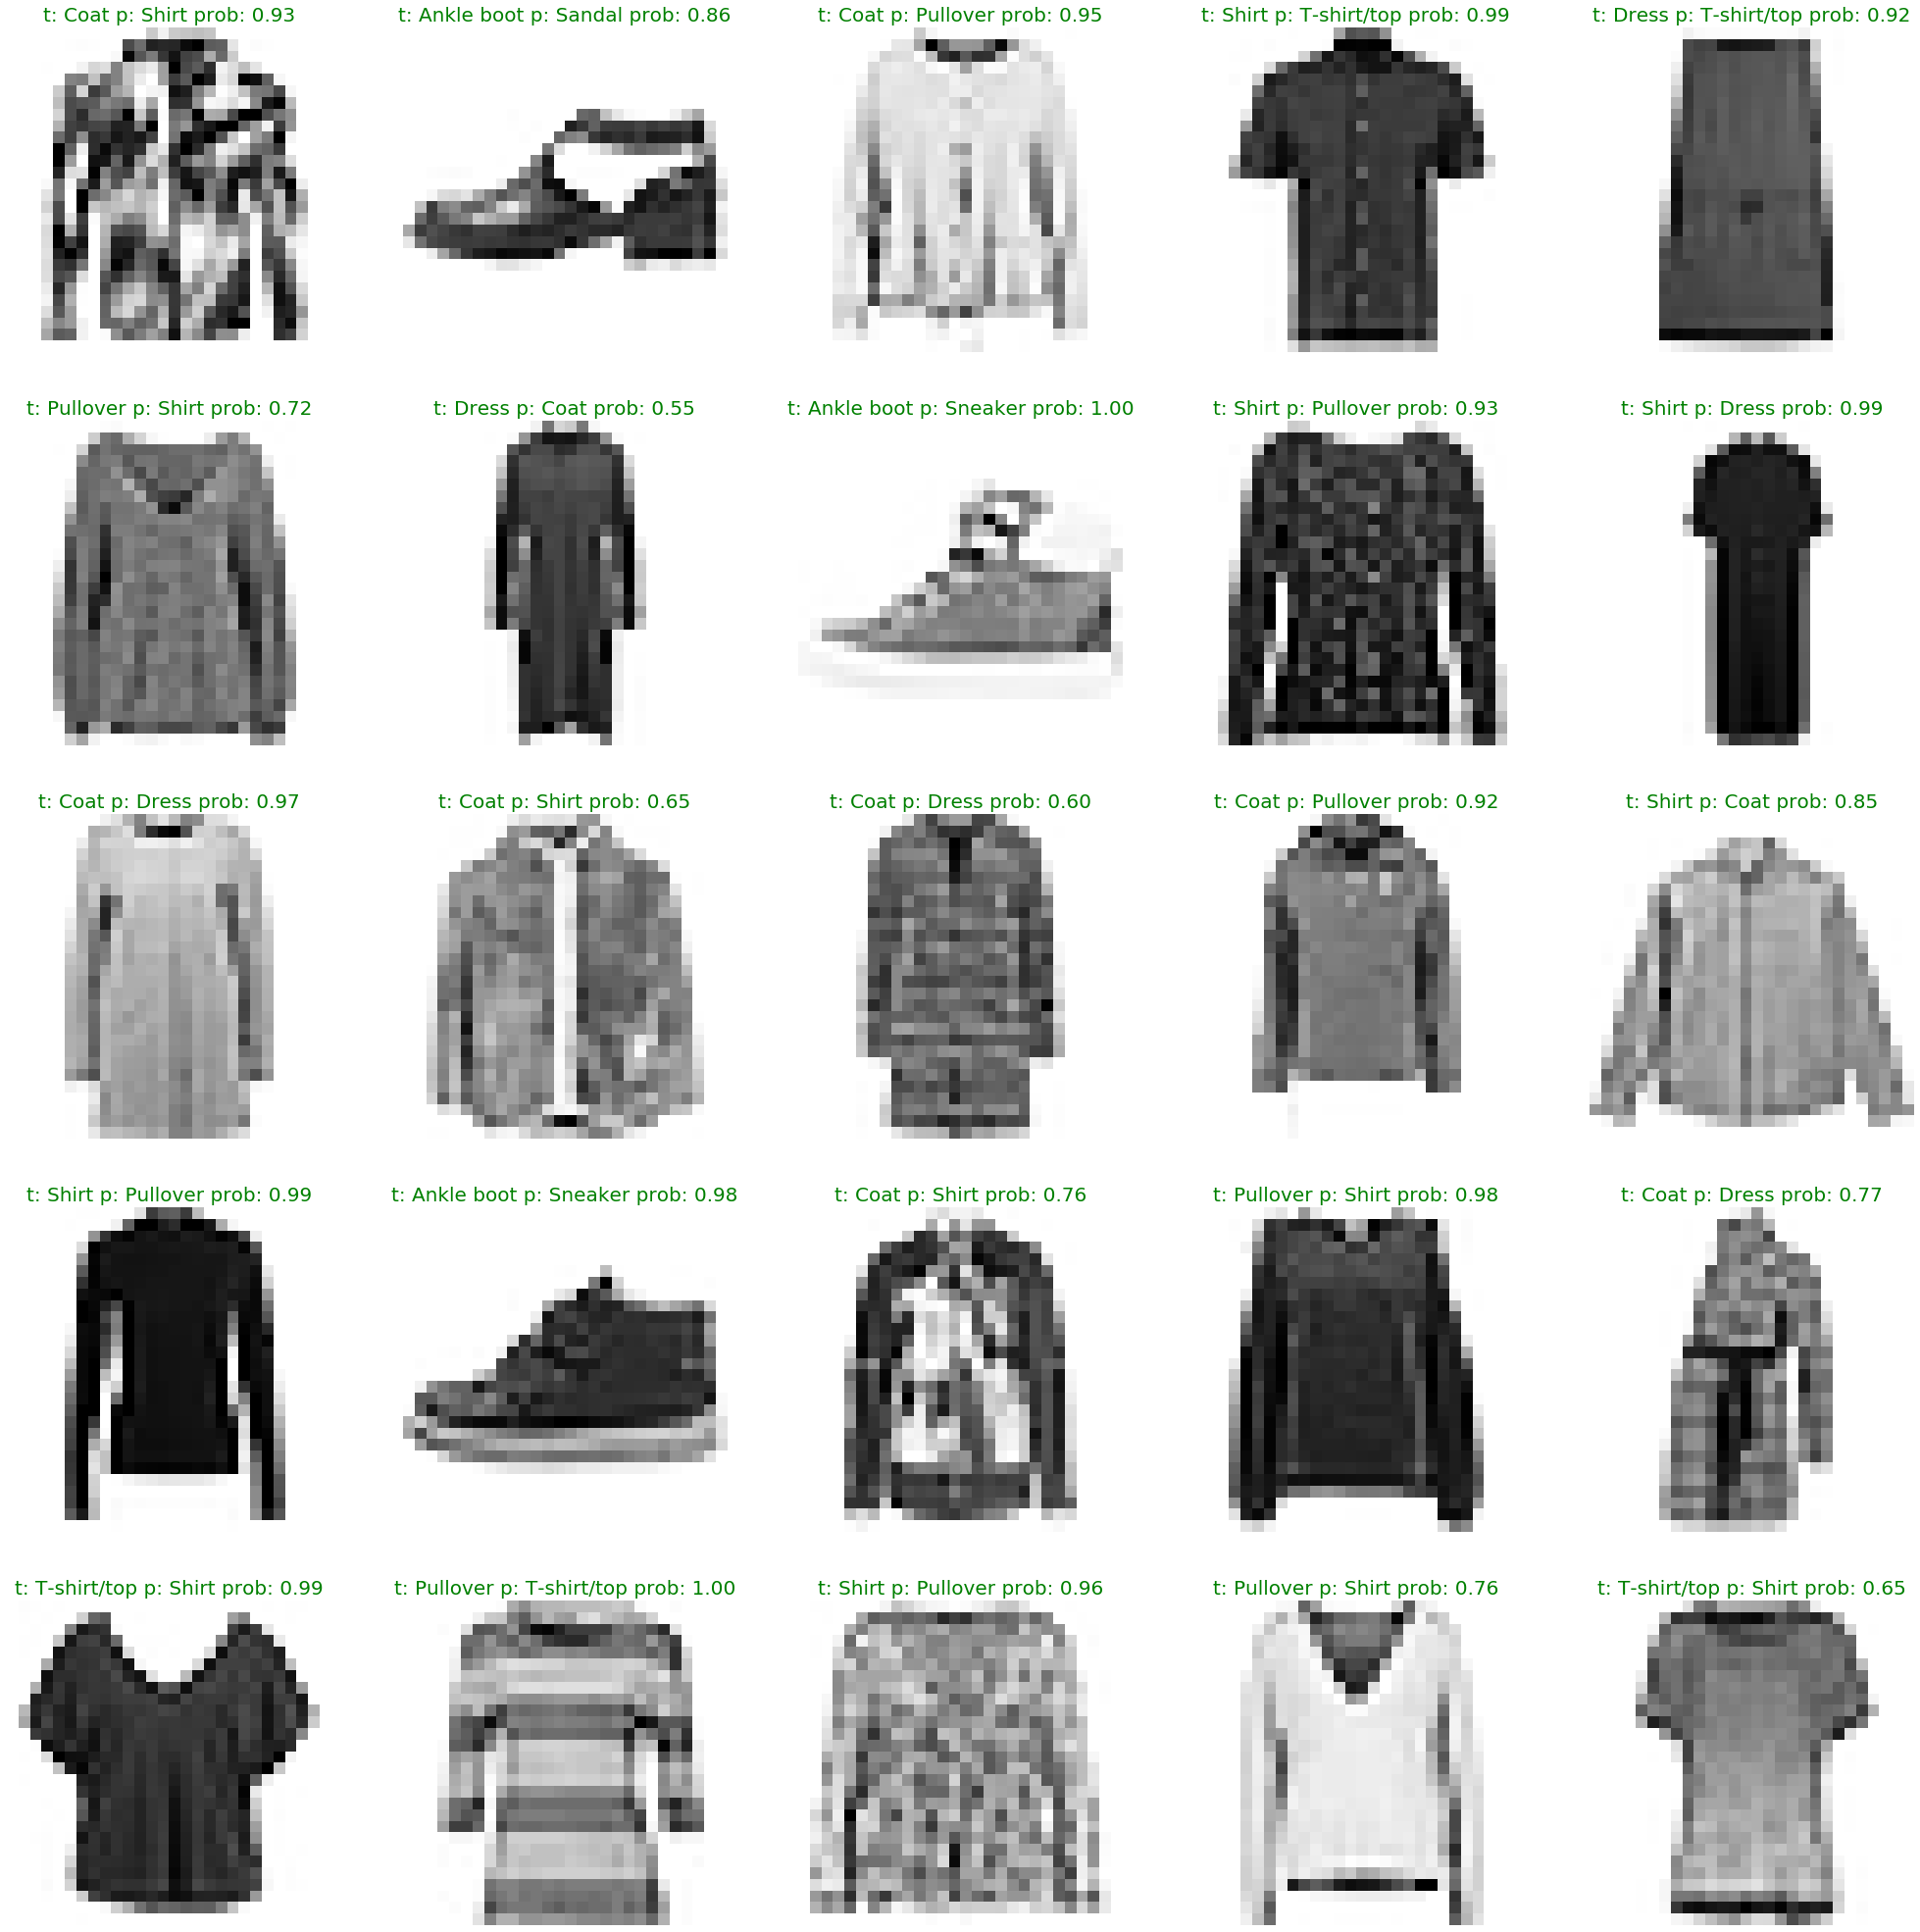

In [69]:
# Visualizing the instances that the model misclassified.
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(28, 28))
ax = ax.flatten()

for num in range(25):
    image = wrong_x[num].reshape(28, 28)
    ax[num].imshow(image, cmap='Greys', interpolation='nearest')
    ax[num].set_title(f"t: {labels[wrong_y_true[num]]} "
                      f"p: {labels[wrong_y_pred[num]]} "
                      f"prob: {wrong_y_proba[num]:.2f}", 
                      fontsize=20, color="green")
    ax[num].axis("off")
plt.tight_layout()


This chart reaffirms the knowledge we gleaned from the confusion matrix. Shirts,
T-Shirt/tops, and coats are hard to separate. Some of these are difficult for 
a human to distinguish.

All in all I am very satisfied with the performance of this model. Given this is
my first CNN end to end project, I feel like I achieved solid results. 

Next I am going to try a harder task... Classifying melanoma! I'm going to try to visualize 
the different layers to gain a deeper understanding/appreciation for convnets.

Cheers!  

